# Input diffused Transformer model

Using small d_model size (e.g. 4 for OHLC) have low representation ability
We can handle a number as a string though, it lost the meaning of the number when we convert it to embedded tensor.
In this notebook, we try to diffuse the small size features by Linear or Conv1d layers.

In [1]:
# For Colab user
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data_folder = "/content/drive/My Drive/Data/FX"
IS_GOOGLE_COLAB = True

Mounted at /content/drive


In [1]:
data_folder = '../../Data/'
IS_GOOGLE_COLAB = False

In [2]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

In [3]:
import sys, os


if IS_GOOGLE_COLAB:
    module_path = os.path.abspath("/content/drive/My Drive/modules")
    sys.path.append(module_path)
    import fprocess
else:
    module_path = os.path.abspath("../..")
    sys.path.append(module_path)
    from fprocess import fprocess

## Linear Input Layer

### Linear Input Layer with Position Embedding

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(-2)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src, tgt):
        src_pos = src.size(0)
        tgt_pos = src_pos + tgt.size(0) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])

In [5]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int, d_model=512, num_layer=2,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.embeded_like_layer = nn.Sequential(
            nn.Linear(feature_size, d_model),
            *(nn.Linear(d_model, d_model) for i in range(1, num_layer))
        )
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.output = nn.Linear(d_model, feature_size)

    def forward(
        self, src: Tensor, tgt: Tensor, mask_tgt: Tensor,
        mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src = self.embeded_like_layer(src)
        tgt = self.embeded_like_layer(tgt)
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.output(outs)

In [6]:
def train(model, ds, optimizer, criterion, batch_size):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds) - batch_size
    for index in tqdm(range(0, end_index, batch_size)):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, tgt=input_tgt,  mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [7]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)

        logits = model(
            src=src, tgt=input_tgt, mask_tgt=mask_tgt,
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

#### Row Data

##### Traininig

In [ ]:
import os
import sys

import pandas as pd

ohlc_column = ['open','high','low','close']
file_path = os.path.abspath('../../Data/mt5_USDJPY_min30.csv')
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.transformer import FeatureDataset
from fprocess import fprocess

In [ ]:
ohlc_column = ['open','high','low','close']
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

#log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
time_p = fprocess.WeeklyIDProcess(freq= 30, time_column= "index")
#ohlc_pre_process = [log_p, diff_p, time_p]
ohlc_pre_process = [diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
observation_length = 60
prediction_length = 10
ds = FeatureDataset(df, columns, observation_length, device, processes, prediction_length, index_sampler="k_fold")

In [ ]:
model_name = "finance_linear_transformer"
model_version = "1"

feature_size = 4
d_model=64
nhead = 4
num_layer=1
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.01

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    d_model=d_model, num_layer=num_layer,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [ ]:
lr = 0.0005

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 5
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 1025/1025 [06:49<00:00,  2.50it/s]


[1/500] train loss: 0.0051358640, valid loss: 0.0015740969  50s] count: 0, **


100%|██████████| 1025/1025 [06:37<00:00,  2.58it/s]


[2/500] train loss: 0.0020535650, valid loss: 0.0014732182  37s] count: 0, **


100%|██████████| 1025/1025 [06:37<00:00,  2.58it/s]


[3/500] train loss: 0.0017062543, valid loss: 0.0015148780  38s] count: 0, 


100%|██████████| 1025/1025 [06:31<00:00,  2.62it/s]


[4/500] train loss: 0.0016169891, valid loss: 0.0014951839  32s] count: 1, 


100%|██████████| 1025/1025 [06:28<00:00,  2.64it/s]


[5/500] train loss: 0.0015847891, valid loss: 0.0012429450  28s] count: 2, **


100%|██████████| 1025/1025 [06:29<00:00,  2.63it/s]


[6/500] train loss: 0.0012135862, valid loss: 0.0009616554  30s] count: 0, **


100%|██████████| 1025/1025 [06:26<00:00,  2.65it/s]


[7/500] train loss: 0.0010432937, valid loss: 0.0009916138  27s] count: 0, 


100%|██████████| 1025/1025 [06:29<00:00,  2.63it/s]


[8/500] train loss: 0.0009865732, valid loss: 0.0009360274  30s] count: 1, **


100%|██████████| 1025/1025 [06:30<00:00,  2.62it/s]


[9/500] train loss: 0.0009824142, valid loss: 0.0008869087  31s] count: 0, **


100%|██████████| 1025/1025 [06:28<00:00,  2.64it/s]


[10/500] train loss: 0.0009466314, valid loss: 0.0009222808  28s] count: 0, 


100%|██████████| 1025/1025 [06:29<00:00,  2.63it/s]


[11/500] train loss: 0.0009310426, valid loss: 0.0010236362  29s] count: 1, 


100%|██████████| 1025/1025 [06:30<00:00,  2.63it/s]


[12/500] train loss: 0.0013249591, valid loss: 0.0008724470  30s] count: 2, **


100%|██████████| 1025/1025 [06:27<00:00,  2.64it/s]


[13/500] train loss: 0.0009124867, valid loss: 0.0008684271  28s] count: 0, **


100%|██████████| 1025/1025 [06:28<00:00,  2.64it/s]


[14/500] train loss: 0.0009050779, valid loss: 0.0008672641  28s] count: 0, **


100%|██████████| 1025/1025 [06:29<00:00,  2.63it/s]


[15/500] train loss: 0.0009028866, valid loss: 0.0008632780  29s] count: 0, **


100%|██████████| 1025/1025 [06:27<00:00,  2.64it/s]


[16/500] train loss: 0.0008944919, valid loss: 0.0009088362  28s] count: 0, 


100%|██████████| 1025/1025 [06:26<00:00,  2.65it/s]


[17/500] train loss: 0.0009118010, valid loss: 0.0008549245  27s] count: 1, **


100%|██████████| 1025/1025 [06:26<00:00,  2.65it/s]


[18/500] train loss: 0.0009409124, valid loss: 0.0008869076  27s] count: 0, 


100%|██████████| 1025/1025 [06:28<00:00,  2.64it/s]


[19/500] train loss: 0.0008911210, valid loss: 0.0008780856  29s] count: 1, 


100%|██████████| 1025/1025 [06:27<00:00,  2.64it/s]


[20/500] train loss: 0.0008846066, valid loss: 0.0008495454  28s] count: 2, **


100%|██████████| 1025/1025 [06:26<00:00,  2.65it/s]


[21/500] train loss: 0.0008808262, valid loss: 0.0008778698  27s] count: 0, 


100%|██████████| 1025/1025 [06:28<00:00,  2.64it/s]


[22/500] train loss: 0.0008934458, valid loss: 0.0010498274  28s] count: 1, 


100%|██████████| 1025/1025 [06:26<00:00,  2.65it/s]


[23/500] train loss: 0.0008766777, valid loss: 0.0008507575  27s] count: 2, 


100%|██████████| 1025/1025 [06:26<00:00,  2.65it/s]


[24/500] train loss: 0.0008641968, valid loss: 0.0008547297  27s] count: 3, 


100%|██████████| 1025/1025 [06:26<00:00,  2.65it/s]


[25/500] train loss: 0.0008607014, valid loss: 0.0008552686  27s] count: 4, 


100%|██████████| 1025/1025 [06:27<00:00,  2.64it/s]


[26/500] train loss: 0.0008546407, valid loss: 0.0008504278  28s] count: 5, 


In [ ]:
torch.save(best_model.state_dict(), f'./{model_name}_v{model_version}.torch')

##### Validation

In [ ]:
model.load_state_dict(torch.load(f'./{model_name}_v{model_version}.torch'))

<All keys matched successfully>

In [ ]:
def prediction(inputs):

    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    while preds.size(0) <= prediction_length:
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, tgt=preds,  mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

In [ ]:
from Dataset import revert_process

ds.eval()
model.eval()

split_factor = 300
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))
        
    preds = prediction(val_inp)
    pre_values = preds.cpu().detach().numpy()
    
    ohlc = revert_process.revert(ds, pre_values, ndx, True, columns)
    
    if factor == 0:
        ohlc_pre = ohlc
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
    
    ans_values = val_ans.cpu().detach().numpy()
    
    temp_ohlc = revert_process.revert(ds, ans_values, ndx, True, columns)
    
    if factor == 0:
        ohlc_ans = temp_ohlc
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)

In [ ]:
print(ohlc_pre.shape, ohlc_ans.shape)

(11, 27807, 4) (11, 27807, 4)


[]

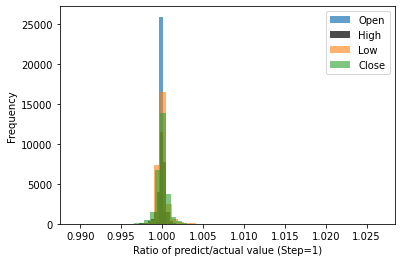

In [ ]:
step=1
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

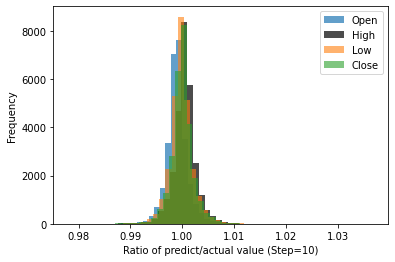

In [ ]:
step=10
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

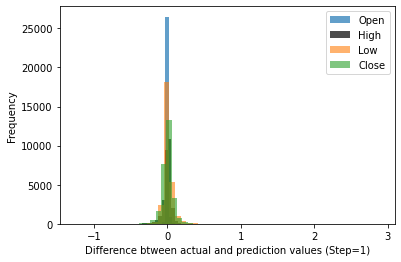

In [ ]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

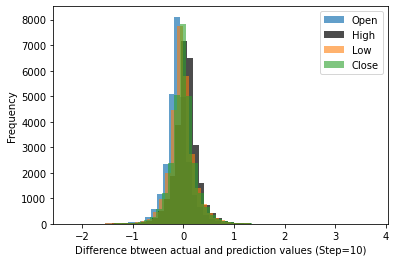

In [ ]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [ ]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.00743 -0.01893 -0.03125 -0.04498 -0.05932 -0.0731  -0.084
 -0.0929  -0.10203 -0.11184]
High [ 0.      -0.00117  0.00386  0.00941  0.01486  0.02136  0.02886  0.03731
  0.04632  0.05454  0.06003]
Low [ 0.00000e+00  5.37881e-03  3.70297e-05 -4.77421e-03 -9.50163e-03
 -1.34603e-02 -1.65097e-02 -1.83224e-02 -1.94195e-02 -2.08608e-02
 -2.36745e-02]
Close [0.      0.0005  0.00098 0.0012  0.00137 0.00144 0.00145 0.00156 0.00167
 0.00174 0.00197]
==============Var============
Open [0.      0.00053 0.00801 0.01524 0.0227  0.03025 0.03769 0.04525 0.05268
 0.06014 0.0674 ]
High [0.      0.00399 0.01119 0.0186  0.02598 0.03341 0.04087 0.04813 0.05536
 0.06241 0.06945]
Low [0.      0.00527 0.01372 0.02173 0.02959 0.03753 0.04535 0.0532  0.06086
 0.06841 0.07592]
Close [0.      0.00743 0.01469 0.02216 0.02967 0.03716 0.04474 0.05222 0.05964
 0.06694 0.0743 ]


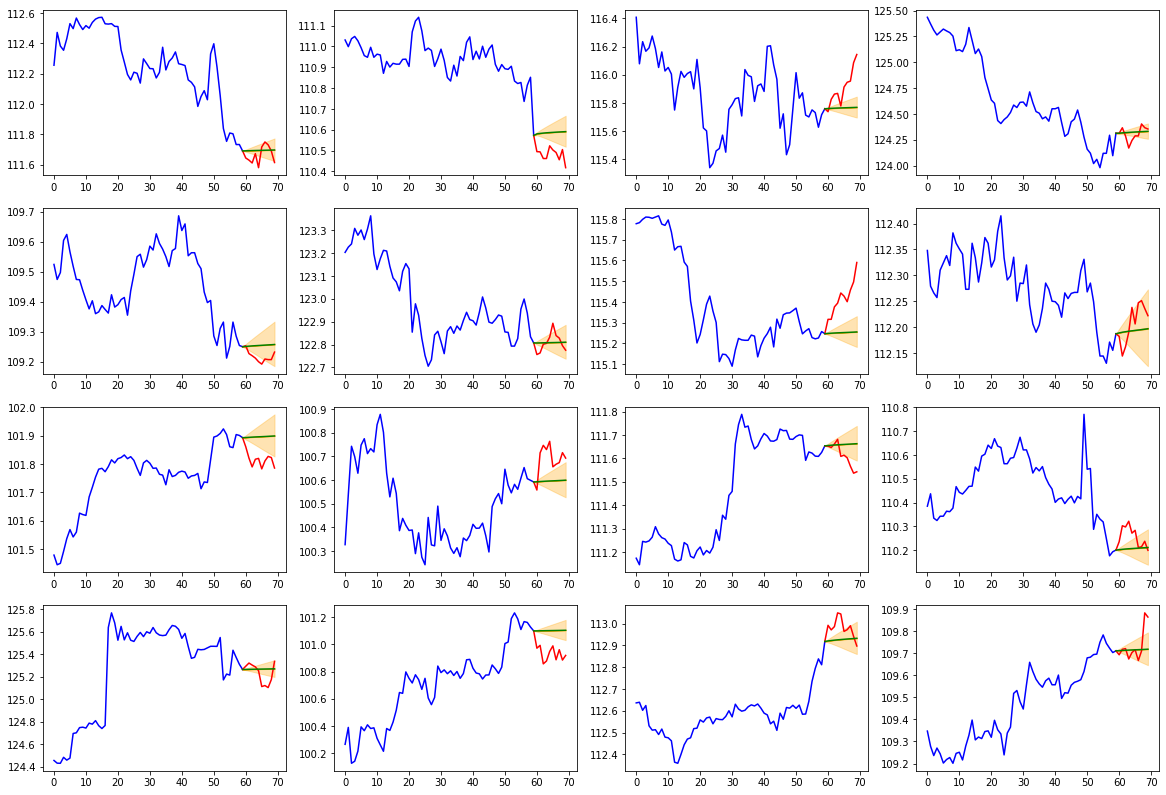

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[3]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 3]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length -1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length -1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 3], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

### Linear Input Layer with Weekly Time Position

In [ ]:
class VariationalDropout(nn.Dropout):
    def forward(self, input):
        if self.training:
            mask = self.get_mask(input)
            return input * mask
        else:
            return input

    def get_mask(self, input):
        return torch.ones_like(input).bernoulli_(1 - self.p) / (1 - self.p)

In [ ]:
class TimePositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(time_size, d_model)

    def forward(self,time_ids):
        position = self.pe(time_ids)
        #tetative approach to fix shape
        position = position.squeeze(2)
        return position

In [ ]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int, 
        feature_size: int, time_size: int, d_model=512, num_layer=2, 
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8,
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.embeded_like_layer = nn.Sequential(
            nn.Linear(feature_size, d_model),
            *(nn.Linear(d_model, d_model) for i in range(1, num_layer))
        )
        
        self.positional_encoding = TimePositionalEncoding(time_size, d_model)
        # self.src_dropaut_layer = VariationalDropout(dropout)
        # self.tgt_dropaut_layer = VariationalDropout(dropout)
        self.src_dropaut_layer = nn.Dropout(dropout)
        self.tgt_dropaut_layer = nn.Dropout(dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.output = nn.Linear(d_model, feature_size)

    def forward(
        self, src: Tensor, src_time, tgt: Tensor, tgt_time,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src = self.embeded_like_layer(src)
        src_time = self.positional_encoding(src_time)
        src = self.src_dropaut_layer(torch.add(src, src_time))
        
        tgt = self.embeded_like_layer(tgt)
        tgt_time = self.positional_encoding(tgt_time)
        tgt = self.tgt_dropaut_layer(torch.add(tgt, tgt_time))
        
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.output(outs)

In [ ]:
def train(model, ds, optimizer, criterion, batch_size):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index - batch_size, batch_size)):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt

        input_tgt = tgt[:-1, :]
        input_time_tgt = tgt_time[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time, 
            tgt=input_tgt, tgt_time=input_time_tgt,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [ ]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt

        input_tgt = tgt[:-1, :]
        input_time_tgt = tgt_time[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time, 
            tgt=input_tgt, tgt_time=input_time_tgt,
            mask_tgt=mask_tgt
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

In [ ]:
import sys

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.transformer import TimeFeatureDataset
import fprocess

#### Row Data

In [ ]:
import os
import pandas as pd

ohlc_column = ['open','high','low','close']
file_path = os.path.abspath(f'{data_folder}/mt5_USDJPY_min30.zip')
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

##### Training

In [ ]:
ohlc_column = ['open','high','low','close']
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

#log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
time_p = fprocess.WeeklyIDProcess(freq= 30, time_column= "index")
#ohlc_pre_process = [log_p, diff_p, time_p]
ohlc_pre_process = [diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_linear_wt_transfomer"
model_version = "2"

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = TimeFeatureDataset(df, columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, index_sampler="k_fold")

In [ ]:
src, tgt = ds[0:batch_size]
for index in range(0, len(ds)):
    src, tgt = ds[index:index+batch_size]
    break
print(src[0].shape, src[1].shape)
print(tgt[0].shape, tgt[1].shape)

torch.Size([60, 64, 4]) torch.Size([60, 64])
torch.Size([11, 64, 4]) torch.Size([11, 64])


In [ ]:
feature_size = 4
d_model=124
nhead = 4
num_layer=1
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.1
time_size = int(24*(60/30)*7)

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=time_size,
    d_model=d_model, num_layer=num_layer,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [ ]:
lr = 0.0005

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
import json
import logging

log_file_path = f"{data_folder}/{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()

print(params)

params = {"processes": [ process.kinds for process in processes],
          "train_data_size": len(ds),
          "d_model": d_model,
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params,
          "type": model_name
}

param_file_path = f"{data_folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

4155712
saved params on  /content/drive/My Drive/Data/FX/finance_linear_wt_transfomer_2_params.json
training log will be saved on  /content/drive/My Drive/Data/FX/finance_linear_wt_transfomer_2.log


In [ ]:
epoch = 100
best_loss = float('Inf')
best_model = None
patience = 5
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))

    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 1100/1100 [03:44<00:00,  4.90it/s]


[1/100] train loss: 0.0485272571, valid loss: 0.0012530667  45s] count: 0, **


100%|██████████| 1100/1100 [03:44<00:00,  4.89it/s]


[2/100] train loss: 0.0020866004, valid loss: 0.0011617920  45s] count: 0, **


100%|██████████| 1100/1100 [03:45<00:00,  4.89it/s]


[3/100] train loss: 0.0018152712, valid loss: 0.0009970852  45s] count: 0, **


100%|██████████| 1100/1100 [03:44<00:00,  4.89it/s]


[4/100] train loss: 0.0014892777, valid loss: 0.0007875692  45s] count: 0, **


100%|██████████| 1100/1100 [03:45<00:00,  4.88it/s]


[5/100] train loss: 0.0012866547, valid loss: 0.0007172256  45s] count: 0, **


100%|██████████| 1100/1100 [04:03<00:00,  4.52it/s]


[6/100] train loss: 0.0012034509, valid loss: 0.0007488735  3s] count: 0, 


100%|██████████| 1100/1100 [03:46<00:00,  4.86it/s]


[7/100] train loss: 0.0011515112, valid loss: 0.0007115639  46s] count: 1, **


100%|██████████| 1100/1100 [03:45<00:00,  4.87it/s]


[8/100] train loss: 0.0010975843, valid loss: 0.0006879483  46s] count: 0, **


100%|██████████| 1100/1100 [03:45<00:00,  4.88it/s]


[9/100] train loss: 0.0010579942, valid loss: 0.0006830370  45s] count: 0, **


100%|██████████| 1100/1100 [03:45<00:00,  4.88it/s]


[10/100] train loss: 0.0010339696, valid loss: 0.0006948703  45s] count: 0, 


100%|██████████| 1100/1100 [03:45<00:00,  4.88it/s]


[11/100] train loss: 0.0010059554, valid loss: 0.0006849885  45s] count: 1, 


100%|██████████| 1100/1100 [03:44<00:00,  4.90it/s]


[12/100] train loss: 0.0009956152, valid loss: 0.0006746227  44s] count: 2, **


100%|██████████| 1100/1100 [03:44<00:00,  4.89it/s]


[13/100] train loss: 0.0010068615, valid loss: 0.0006690622  45s] count: 0, **


100%|██████████| 1100/1100 [03:47<00:00,  4.83it/s]


[14/100] train loss: 0.0010162500, valid loss: 0.0007007118  48s] count: 0, 


100%|██████████| 1100/1100 [03:48<00:00,  4.82it/s]


[15/100] train loss: 0.0009629153, valid loss: 0.0006673990  48s] count: 1, **


100%|██████████| 1100/1100 [03:46<00:00,  4.85it/s]


[16/100] train loss: 0.0009648981, valid loss: 0.0006785975  47s] count: 0, 


100%|██████████| 1100/1100 [03:45<00:00,  4.88it/s]


[17/100] train loss: 0.0009479790, valid loss: 0.0006686455  45s] count: 1, 


100%|██████████| 1100/1100 [03:44<00:00,  4.91it/s]


[18/100] train loss: 0.0009378466, valid loss: 0.0006643658  44s] count: 2, **


100%|██████████| 1100/1100 [03:43<00:00,  4.91it/s]


[19/100] train loss: 0.0009308330, valid loss: 0.0006544470  44s] count: 0, **


100%|██████████| 1100/1100 [03:44<00:00,  4.89it/s]


[20/100] train loss: 0.0009171298, valid loss: 0.0006499873  45s] count: 0, **


100%|██████████| 1100/1100 [03:45<00:00,  4.89it/s]


[21/100] train loss: 0.0009155292, valid loss: 0.0006584162  45s] count: 0, 


100%|██████████| 1100/1100 [03:45<00:00,  4.87it/s]


[22/100] train loss: 0.0009028001, valid loss: 0.0006611931  46s] count: 1, 


100%|██████████| 1100/1100 [03:45<00:00,  4.88it/s]


[23/100] train loss: 0.0008994494, valid loss: 0.0006785247  46s] count: 2, 


100%|██████████| 1100/1100 [03:44<00:00,  4.89it/s]


[24/100] train loss: 0.0008869487, valid loss: 0.0006721357  45s] count: 3, 


100%|██████████| 1100/1100 [03:44<00:00,  4.89it/s]


[25/100] train loss: 0.0008810645, valid loss: 0.0006962285  45s] count: 4, 


100%|██████████| 1100/1100 [03:42<00:00,  4.94it/s]


[26/100] train loss: 0.0008649924, valid loss: 0.0006631011  43s] count: 5, 


In [ ]:
torch.save(best_model.state_dict(), f'{data_folder}/{model_name}_{model_version}.torch')

In [ ]:
import time
from google.colab import runtime

#drive.flush_and_unmount()
runtime.unassign()

##### Validation

In [ ]:
model.load_state_dict(torch.load(f'{data_folder}/{model_name}_{model_version}.torch'))

<All keys matched successfully>

In [ ]:
model.eval()
ds.eval()

In [ ]:
def prediction(inputs, tgt_time_org):
    inputs, src_time = inputs
    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    # instead of caliculate next tick time, use tgt_time provided by dataset
    tgt_time = tgt_time_org[:1, :]
    while preds.size(0) <= prediction_length:
        current_length = preds.size(0)
        tgt_time = tgt_time_org[:current_length, :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, src_time=src_time,
                    tgt=preds, tgt_time=tgt_time,
                    mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

In [ ]:
from Dataset import revert_process

ds.eval()
model.eval()

split_factor = 1000
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))
        
    preds = prediction(val_inp, val_ans[1])
    pre_values = preds.cpu().detach().numpy()
    
    ohlc = revert_process.revert(ds, pre_values, ndx, True, columns=ohlc_column)
    
    if factor == 0:
        ohlc_pre = ohlc
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
    
    ans_values = val_ans[0].cpu().detach().numpy()
    
    temp_ohlc = revert_process.revert(ds, ans_values, ndx, True, columns=ohlc_column)
    
    if factor == 0:
        ohlc_ans = temp_ohlc
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)

In [ ]:
print(ohlc_pre.shape, ohlc_ans.shape)

(11, 29970, 4) (11, 29970, 4)


[]

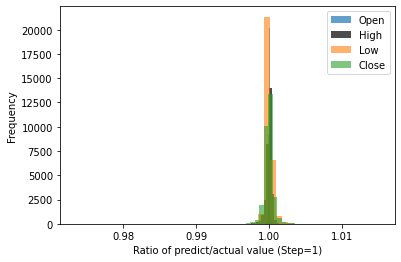

In [ ]:
step=1
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

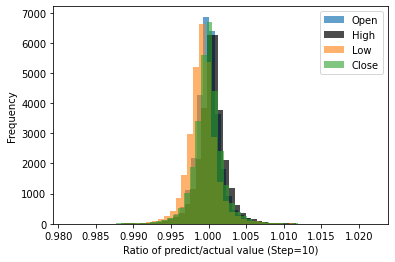

In [ ]:
step=10
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

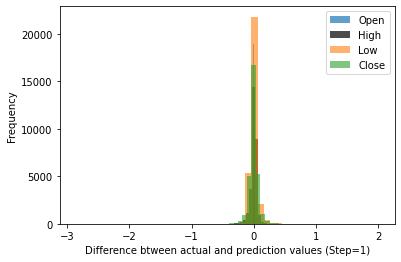

In [ ]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

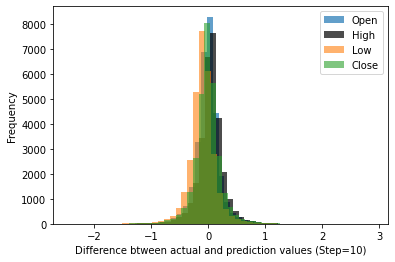

In [ ]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [ ]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.       0.00021 -0.00102 -0.00183 -0.00238 -0.00287 -0.00336 -0.00411
 -0.00492 -0.00587 -0.00692]
High [0.      0.00137 0.00716 0.01338 0.01932 0.02538 0.03124 0.03681 0.0422
 0.04745 0.05253]
Low [ 0.      -0.00285 -0.01463 -0.02543 -0.03577 -0.04588 -0.05606 -0.06607
 -0.07624 -0.08647 -0.09683]
Close [ 0.      -0.00152 -0.00269 -0.00343 -0.00404 -0.00449 -0.00519 -0.00591
 -0.00678 -0.00773 -0.00886]
==============Var============
Open [0.00000e+00 9.28018e-05 6.76288e-03 1.26226e-02 1.87984e-02 2.48281e-02
 3.10049e-02 3.70849e-02 4.33855e-02 4.97927e-02 5.59080e-02]
High [0.      0.00324 0.00951 0.01553 0.02163 0.02769 0.03395 0.04001 0.04655
 0.05292 0.0591 ]
Low [0.      0.00428 0.01077 0.01724 0.02365 0.02975 0.03592 0.04216 0.04879
 0.05518 0.06154]
Close [0.      0.00651 0.01241 0.01858 0.02462 0.03074 0.03673 0.04298 0.04935
 0.05542 0.06175]


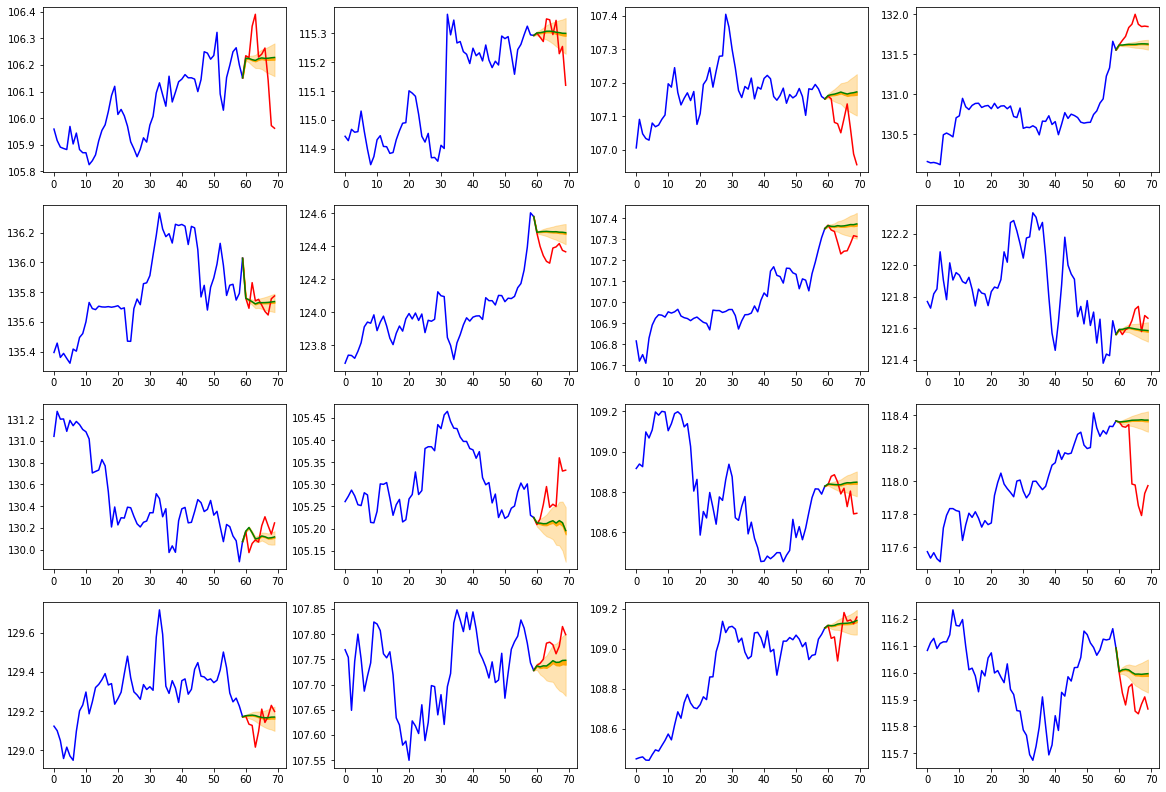

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[0]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 0]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length-1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length-1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 0], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

#### Row Data (More data range)

In [ ]:
import zipfile
import os
import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d %H%M%S'), index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

In [ ]:
import pandas as pd
import glob

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"
file_path = f"{data_folder}/HistData_USDJPY_30MIN.zip"

if os.path.exists(file_path):
    df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
else:
    file_path = f"{data_folder}/HistData_USDJPY_30MIN.csv"

    if os.path.exists(file_path):
        df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
        files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

        for file in files:
            min_df = read_histdata_file(file)
            rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
            rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
            rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
            rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
            rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
            rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
            rolled_df.dropna(inplace=True)
            df = pd.concat([df, rolled_df], axis=0)
        df.to_csv(f"{data_folder}/HistData_USDJPY_1MIN.csv")
df

##### Training

In [ ]:
ohlc_column = ['open','high','low','close']
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

#log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
time_p = fprocess.WeeklyIDProcess(freq= 30, time_column= "index")
#ohlc_pre_process = [log_p, diff_p, time_p]
ohlc_pre_process = [diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_linear_wt_transfomer_ext"

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = TimeFeatureDataset(df, columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, index_sampler="k_fold")

In [ ]:
feature_size = 4
d_model=124
nhead = 4
num_layer=1
dim_feedforward = 10
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.1
time_size = int(24*(60/30)*7)

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=time_size,
    d_model=d_model, num_layer=num_layer,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [ ]:
lr = 0.0005

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
import json
import logging

model_version = "1"
log_file_path = f"{data_folder}/{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()

print(params)

params = {"processes": [ process.kinds for process in processes],
          "train_data_size": len(ds),
          "d_model": d_model,
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params,
          "type": model_name
}

param_file_path = f"{data_folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

In [ ]:
epoch = 100
best_loss = float('Inf')
best_model = None
patience = 5
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))

    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

In [ ]:
torch.save(best_model.state_dict(), f'{data_folder}/{model_name}_{model_version}.torch')

##### Validation

#### Argumented Data with Shift Rolling

In [ ]:
import zipfile
import os
import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d %H%M%S'), index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

In [ ]:
import glob
import os
import pandas as pd

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"
file_path = f"{data_folder}/HistData_USDJPY_1MIN.zip"
if os.path.exists(file_path):
  df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
else:
  file_path = f"{data_folder}/HistData_USDJPY_1MIN.csv"

  if os.path.exists(file_path):
      df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
  else:
      folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
      files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

      for file in files:
          min_df = read_histdata_file(file)
          df = pd.concat([df, min_df], axis=0)
      df.to_csv(f"{data_folder}/HistData_USDJPY_1MIN.csv")

In [ ]:
freq = 30
freq_str = "30MIN"

org_df = df.groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()

DFS = []
BIAS = 2

for bias in range(-BIAS, BIAS+1):
    min_df = df.copy()
    min_df.index += pd.Timedelta(minutes=bias)
    rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()
    rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq=freq_str)).max().dropna()
    rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq=freq_str)).min().dropna()
    rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq=freq_str)).last().dropna()
    #rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq=freq_str)).sum()
    #rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
    rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close], axis=1)
    rolled_df = rolled_df[rolled_df.index.isin(org_df.index)]
    DFS.append(rolled_df)

In [ ]:
def train(model, ds_array, optimizer, criterion, batch_size, device):
    
    model.train()
    losses = 0
    length = 0
    end_index = 0
    
    mini_batch = int(batch_size/len(ds_array))
    if mini_batch <= 1:
        mini_batch = 2
        
    ds_length = []
    for ds in ds_array:
        ds_length.append(len(ds))
        ds.train()
    
    end_index = min(ds_length)
    
    end = False
    for index in tqdm(range(0, end_index - mini_batch, mini_batch)):
        length+=1.0
        sources = []
        sources_time = []
        targets = []
        targets_time = []
        for ds in ds_array:
            try:
                src, tgt = ds[index:index+mini_batch]
                src, src_time = src
                tgt, tgt_time = tgt
                sources.append(src)
                sources_time.append(src_time)
                targets.append(tgt)
                targets_time.append(tgt_time)
            except:
                end = True
                break
        if end:
            break
        src = torch.concat(sources, dim=1)
        src_time = torch.concat(sources_time, dim=1)
        tgt = torch.concat(targets, dim=1)
        tgt_time = torch.concat(targets_time, dim=1)

        input_tgt = tgt[:-1, :]
        input_time_tgt = tgt_time[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time, 
            tgt=input_tgt, tgt_time=input_time_tgt,
            mask_tgt=mask_tgt
        )        

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [ ]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt

        input_tgt = tgt[:-1, :]
        input_time_tgt = tgt_time[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time, 
            tgt=input_tgt, tgt_time=input_time_tgt,
            mask_tgt=mask_tgt
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

##### Training

In [ ]:
ds_array = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_linear_wt_transfomer_shift-arg"

for df_ in DFS:
  ohlc_column = ['open','high','low','close']
  #volume_column = ["tick_volume"]
  #columns = ohlc_column+volume_column
  columns = ohlc_column

  #log_p = fprocess.LogPreProcess(columns=ohlc_column)
  diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
  time_p = fprocess.WeeklyIDProcess(freq=freq, time_column= "index")
  #ohlc_pre_process = [log_p, diff_p, time_p]
  ohlc_pre_process = [diff_p, time_p]

  standalization_p = fprocess.MinMaxPreProcess(columns=columns)
  processes = [*ohlc_pre_process, standalization_p]

  #Dataset parameters
  batch_size = 64
  observation_length = 60
  prediction_length = 10

  ds = TimeFeatureDataset(df_, columns, time_column="index",
                          processes=processes, observation_length=observation_length,
                          prediction_length=prediction_length, device=device)
  ds_array.append(ds)

In [ ]:
feature_size = 4
d_model=124
nhead = 4
num_layer=1
dim_feedforward = 10
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.1
time_size = int(24*(60/30)*7)

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=time_size,
    d_model=d_model, num_layer=num_layer,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [ ]:
lr = 0.00005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
import json
import logging

model_version = "1"
log_file_path = f"{data_folder}/{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()

print(params)

params = {"processes": [ process.kinds for process in processes],
          "train_data_size": len(ds),
          "d_model": d_model,
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params,
          "type": model_name
}

param_file_path = f"{data_folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

In [ ]:
logger.debug("start training")

epoch = 500
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

ACTUAL_DS_INDEX = BIAS

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds_array=ds_array, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds_array[ACTUAL_DS_INDEX], criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    )
    print(log)
    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
          
    if counter > patience:
        break

### Linear Input Layer with Position Learning

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, position_size, d_model, dropout):
        super().__init__()
        self.pe = nn.Embedding(position_size, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, position_ids):
        position = self.pe(position_ids)
        return self.dropout(position)

In [5]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int, 
        feature_size: int,  observation_length, prediction_length,
        d_model=512, num_layer=2, dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8,
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.embeded_like_layer = nn.Sequential(
            nn.Linear(feature_size, d_model),
            *(nn.Linear(d_model, d_model) for i in range(1, num_layer))
        )
        
        self.positional_encoding = PositionalEncoding(observation_length + prediction_length, d_model, dropout=dropout)
        # self.src_dropaut_layer = VariationalDropout(dropout)
        # self.tgt_dropaut_layer = VariationalDropout(dropout)
        self.src_dropaut_layer = nn.Dropout(dropout)
        self.tgt_dropaut_layer = nn.Dropout(dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.output = nn.Linear(d_model, feature_size)

    def forward(
        self, src: Tensor, src_positions, tgt: Tensor, tgt_positions,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src = self.embeded_like_layer(src)
        src_positions = self.positional_encoding(src_positions)
        src = self.src_dropaut_layer(torch.add(src, src_positions))
        
        tgt = self.embeded_like_layer(tgt)
        tgt_positions = self.positional_encoding(tgt_positions)
        tgt = self.tgt_dropaut_layer(torch.add(tgt, tgt_positions))
        
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.output(outs)

In [6]:
def fit(model, src, tgt):
    src = src.transpose(0, 1)
    tgt = tgt.transpose(0, 1)
    input_tgt = tgt[:-1, :]
    

    obs_length = src.shape[0]
    batch_length = src.shape[1]
    src_positions = torch.arange(0, obs_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_length).to(device)
    tgt_positions = torch.arange(obs_length, obs_length + input_tgt.shape[0], 1, dtype=torch.int).reshape(input_tgt.shape[0], 1).repeat(1, batch_length).to(device)

    mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
    logits = model(
        src=src, src_positions=src_positions, 
        tgt=input_tgt, tgt_positions=tgt_positions,
        mask_tgt=mask_tgt
    )
    output_tgt = tgt[1:, :]
    return logits, output_tgt

In [7]:
def train(model, dl, optimizer, criterion, batch_size):
    
    model.train()
    dl.dataset.train()
    losses = 0
    
    length = 0.0
    for src, tgt in tqdm(dl):
        length+=1.0

        logits, output_tgt = fit(model, src, tgt)

        optimizer.zero_grad()
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [8]:
def evaluate(model, dl, criterion, batch_size):
    
    model.eval()
    dl.dataset.eval()
    losses = 0
    length = 0.0
    for src, tgt in dl:
        length+=1.0
        
        logits, output_tgt = fit(model, src, tgt)
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

In [9]:
import sys

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.transformer import FeatureDataset

#### Row Data

In [10]:
import os
import pandas as pd

ohlc_column = ['open','high','low','close']
file_path = os.path.abspath(f'{data_folder}/mt5_USDJPY_min30.csv')
df = pd.read_csv(file_path, index_col=0, parse_dates=True)
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0
...,...,...,...,...,...,...,...
2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0
2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0
2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0


##### Training

In [11]:
ohlc_column = ['open','high','low','close']
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

#log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
#time_p = fprocess.WeeklyIDProcess(freq= 30, time_column= "index")
#ohlc_pre_process = [log_p, diff_p, time_p]
ohlc_pre_process = [diff_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = FeatureDataset(df, columns, device=device,
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, index_sampler="k_fold")
dl = DataLoader(ds, batch_size=64, shuffle=True, num_workers=1, drop_last=True, collate_fn=None)

In [13]:
feature_size = 4
d_model=124
nhead = 4
num_layer=1
dim_feedforward = 1000
num_encoder_layers = 12
num_decoder_layers = 12
dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    observation_length=observation_length,
    prediction_length=prediction_length,
    d_model=d_model, num_layer=num_layer,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [14]:
lr = 0.0005

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [15]:
import json
import logging

model_name = "finance_linear_pl_transfomer"
model_version = "3"

log_file_path = f"{data_folder}/{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()

print(params)

params = {"processes": [ process.kinds for process in processes],
          "train_data_size": len(ds),
          "d_model": d_model,
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params,
          "type": model_name
}

param_file_path = f"{data_folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

8235656
saved params on  ../../Data//finance_linear_pl_transfomer_3_params.json
training log will be saved on  ../../Data//finance_linear_pl_transfomer_3.log


In [ ]:
epoch = 100
best_loss = float('Inf')
best_model = None
patience = 5
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, dl=dl, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, dl=dl, criterion=criterion,batch_size=batch_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))

    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

In [ ]:
torch.save(best_model.state_dict(), f'{data_folder}/{model_name}_{model_version}.torch')

In [ ]:
import time
from google.colab import runtime

#drive.flush_and_unmount()
runtime.unassign()

##### Validation

#### Row Data (Moew data range)

In [9]:
import zipfile
import os
import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d %H%M%S'), index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

In [17]:
import pandas as pd
import glob

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"
file_path = f"{data_folder}/HistData_USDJPY_30min.zip"

if os.path.exists(file_path):
    df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
else:
    file_path = f"{data_folder}/HistData_USDJPY_30MIN.csv"

    if os.path.exists(file_path):
        df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
        files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

        for file in files:
            min_df = read_histdata_file(file)
            rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
            rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
            rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
            rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
            rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
            rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
            rolled_df.dropna(inplace=True)
            df = pd.concat([df, rolled_df], axis=0)
        df.to_csv(f"{data_folder}/HistData_USDJPY_1MIN.csv")
df

,open,high,low,close,volume
time,,,,,
2000-05-30 17:30:00,106.600,106.600,106.600,106.600,0
2000-05-30 18:00:00,106.650,106.660,106.640,106.660,0
2000-05-30 18:30:00,106.670,106.670,106.580,106.600,0
2000-05-30 19:00:00,106.620,106.640,106.620,106.620,0
2000-05-30 19:30:00,106.640,106.690,106.640,106.690,0
...,...,...,...,...,...
2022-12-30 14:30:00,130.952,131.020,130.925,130.971,0
2022-12-30 15:00:00,130.969,131.132,130.969,131.051,0
2022-12-30 15:30:00,131.050,131.291,130.996,131.269,0


##### Training

In [18]:
ohlc_column = ['open','high','low','close']
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

#log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
#ohlc_pre_process = [log_p, diff_p, time_p]
ohlc_pre_process = [diff_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = FeatureDataset(df, columns, processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, index_sampler="k_fold", device=device)

dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=1, drop_last=True)

In [20]:
feature_size = 4
d_model=124
nhead = 4
num_layer=1
dim_feedforward = 1000
num_encoder_layers = 12
num_decoder_layers = 12
dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    observation_length=observation_length,
    prediction_length=prediction_length,
    d_model=d_model, num_layer=num_layer,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [21]:
lr = 0.0005

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [23]:
import json
import logging

model_name = f"finance_linear{num_layer}_pl_transfomer_ext"
model_version = "1"
log_file_path = f"{data_folder}/{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()

print(params)

params = {"processes": [ process.kinds for process in processes],
          "train_data_size": len(ds),
          "d_model": d_model,
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params,
          "type": model_name
}

param_file_path = f"{data_folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

8235656
saved params on  ../../Data//finance_linear1_pl_transfomer_ext_1_params.json
training log will be saved on  ../../Data//finance_linear1_pl_transfomer_ext_1.log


In [ ]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 5
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, dl=dl, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, dl=dl, criterion=criterion,batch_size=batch_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))

    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

In [ ]:
torch.save(best_model.state_dict(), f'{data_folder}/{model_name}_{model_version}.torch')

In [ ]:
import time
from google.colab import runtime

#drive.flush_and_unmount()
runtime.unassign()

##### Validation

In [20]:
model.load_state_dict(torch.load(f'{data_folder}/{model_name}_{model_version}.torch'))

<All keys matched successfully>

#### Argumented Data with Shift Rolling

In [9]:
import zipfile
import os
import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d %H%M%S'), index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

In [10]:
import glob
import os
import pandas as pd

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"
file_path = f"{data_folder}/HistData_USDJPY_1MIN.zip"
if os.path.exists(file_path):
  df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
else:
  file_path = f"{data_folder}/HistData_USDJPY_1MIN.csv"

  if os.path.exists(file_path):
      df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
  else:
      folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
      files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

      for file in files:
          min_df = read_histdata_file(file)
          df = pd.concat([df, min_df], axis=0)
      df.to_csv(f"{data_folder}/HistData_USDJPY_1MIN.csv")
df

,open,high,low,close,volume
time,,,,,
2000-05-30 17:58:00,106.600,106.600,106.600,106.600,0
2000-05-30 18:03:00,106.650,106.650,106.650,106.650,0
2000-05-30 18:19:00,106.640,106.650,106.640,106.650,0
2000-05-30 18:28:00,106.660,106.660,106.660,106.660,0
2000-05-30 18:33:00,106.670,106.670,106.670,106.670,0
...,...,...,...,...,...
2022-12-30 16:54:00,131.111,131.123,131.091,131.112,0
2022-12-30 16:55:00,131.109,131.119,131.090,131.101,0
2022-12-30 16:56:00,131.109,131.110,131.069,131.090,0


In [11]:
freq = 30
freq_str = "30MIN"

org_df = df.groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()

DFS = []
BIAS = 2

for bias in range(-BIAS, BIAS+1):
    min_df = df.copy()
    min_df.index += pd.Timedelta(minutes=bias)
    rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()
    rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq=freq_str)).max().dropna()
    rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq=freq_str)).min().dropna()
    rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq=freq_str)).last().dropna()
    #rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq=freq_str)).sum()
    #rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
    rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close], axis=1)
    rolled_df = rolled_df[rolled_df.index.isin(org_df.index)]
    DFS.append(rolled_df)

In [12]:
def train(model, ds_array, optimizer, criterion, batch_size, device):
    
    model.train()
    losses = 0
    length = 0
    end_index = 0
    
    mini_batch = int(batch_size/len(ds_array))
    if mini_batch <= 1:
        mini_batch = 2
        
    ds_length = []
    for ds in ds_array:
        ds_length.append(len(ds))
        ds.train()
    
    end_index = min(ds_length)
    
    end = False
    for index in tqdm(range(0, end_index - mini_batch, mini_batch)):
        length+=1.0
        sources = []
        targets = []
        for ds in ds_array:
            try:
                src, tgt = ds[index:index+mini_batch]
                sources.append(src)
                targets.append(tgt)
            except:
                end = True
                break
        if end:
            break
        src = torch.concat(sources, dim=1)
        tgt = torch.concat(targets, dim=1)

        obs_length = src.shape[0]
        batch_length = src.shape[1]
        input_tgt = tgt[:-1, :]
        src_positions = torch.arange(0, obs_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_length).to(device)
        tgt_positions = torch.arange(obs_length, obs_length + input_tgt.shape[0], 1, dtype=torch.int).reshape(input_tgt.shape[0], 1).repeat(1, batch_length).to(device)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)

        logits = model(
            src=src, src_positions=src_positions, 
            tgt=input_tgt, tgt_positions=tgt_positions,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [13]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        length+=1.0
        src, tgt = ds[index:index+batch_size]

        input_tgt = tgt[:-1, :]
        obs_length = src.shape[0]
        batch_length = src.shape[1]
        src_positions = torch.arange(0, obs_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_length).to(device)
        tgt_positions = torch.arange(obs_length, obs_length + input_tgt.shape[0], 1, dtype=torch.int).reshape(input_tgt.shape[0], 1).repeat(1, batch_length).to(device)        

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_positions=src_positions,
            tgt=input_tgt, tgt_positions=tgt_positions,
            mask_tgt=mask_tgt
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

##### Training

In [14]:
ds_array = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

for df_ in DFS:
  ohlc_column = ['open','high','low','close']
  #volume_column = ["tick_volume"]
  #columns = ohlc_column+volume_column
  columns = ohlc_column

  #log_p = fprocess.LogPreProcess(columns=ohlc_column)
  diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
  #time_p = fprocess.WeeklyIDProcess(freq=freq, time_column= "index")
  #ohlc_pre_process = [log_p, diff_p, time_p]
  ohlc_pre_process = [diff_p]

  standalization_p = fprocess.MinMaxPreProcess(columns=columns)
  processes = [*ohlc_pre_process, standalization_p]


  ds = FeatureDataset(df_, columns, processes=processes, observation_length=observation_length,
                          prediction_length=prediction_length, device=device)
  ds_array.append(ds)

In [15]:
feature_size = 4
d_model=124
nhead = 4
num_layer=1
dim_feedforward = 1000
num_encoder_layers = 12
num_decoder_layers = 12
dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    observation_length=observation_length,
    prediction_length=prediction_length,
    d_model=d_model, num_layer=num_layer,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [16]:
lr = 0.00005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [17]:
import json
import logging

model_name = f"finance_linear_pl_transfomer_shift{BIAS}"

model_version = "3"
log_file_path = f"{data_folder}/{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()

print(params)

params = {"processes": [ process.kinds for process in processes],
          "train_data_size": len(ds),
          "d_model": d_model,
          "source": file_path,
          "freq":30,
          "length": len(ds),
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params,
          "type": model_name
}

param_file_path = f"{data_folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

8235656
saved params on  ../../Data//finance_linear_pl_transfomer_shift2_3_params.json
training log will be saved on  ../../Data//finance_linear_pl_transfomer_shift2_3.log


In [ ]:
epoch = 100
best_loss = float('Inf')
best_model = None
patience = 5
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds_array=ds_array, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size, device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size, device=device
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))

    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

##### Validation

## Conv1d Input Layer